In [3]:
import os
import turicreate as tc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from turicreate.toolkits import _pre_trained_models
from turicreate.toolkits import _image_feature_extractor

In [4]:
ptModel = _pre_trained_models.SqueezeNetImageClassifierV1_1()
feature_extractor = _image_feature_extractor.TensorFlowFeatureExtractor(ptModel)

In [5]:
train_data = tc.image_analysis.load_images("gemstone/train", with_path=True)
train_features = feature_extractor.extract_features(train_data,
                                          "image", verbose=True)

Performing feature extraction on resized images...
Completed  64/287
Completed 128/287
Completed 192/287
Completed 256/287
Completed 287/287


In [6]:
train_data["label"] = train_data["path"].apply(lambda path:
                                              os.path.basename(os.path.split(path)[0]))

extracted_train_features = tc.SFrame({
    "label": train_data["label"],
    '__image_features__': train_features,
    })

extracted_train_features.save("extracted_train_features.sframe")
extracted_train_features = tc.SFrame("extracted_train_features.sframe")
extracted_train_features.head()

__image_features__,label
"[12.246874809265137,10.5948486328125, ...",Aquamarine
"[7.081120491027832,10.476655960083008, ...",Aquamarine
"[11.587231636047363,15.5217866897583, ...",Aquamarine
"[5.346592426300049,10.991842269897461, ...",Aquamarine
"[12.400737762451172,12.429574012756348, ...",Aquamarine
"[10.295933723449707,12.65181827545166, ...",Aquamarine
"[6.958984851837158,11.899666786193848, ...",Aquamarine
"[8.716665267944336,6.1110148429870605, ...",Aquamarine
"[9.774314880371094,10.537230491638184, ...",Aquamarine
"[5.094823360443115,3.911597728729248, ...",Aquamarine


In [7]:
val_data = tc.image_analysis.load_images("gemstone/validation", with_path=True)
val_data["label"] = val_data["path"].apply(lambda path:
      os.path.basename(os.path.split(path)[0]))

In [8]:
val_features = feature_extractor.extract_features(val_data,
                                      "image", verbose=True)

extracted_val_features = tc.SFrame({
    "label": val_data["label"],
    '__image_features__': val_features,
    })

extracted_val_features.save("extracted_val_features.sframe")  

Performing feature extraction on resized images...
Completed  64/120
Completed 120/120


In [9]:
test_data = tc.image_analysis.load_images("gemstone/test", with_path=True)
test_data["label"] = test_data["path"].apply(lambda path:
                                              os.path.basename(os.path.split(path)[0]))

In [10]:
def summary_eval(test_data):
    
    metrics = model.evaluate(test_data)
    print("Accuracy: ", metrics["accuracy"])
    print("Precision: ", metrics["precision"])
    print("Recall: ", metrics["recall"])
    
    return metrics

In [11]:
lr_model = tc.logistic_classifier.create(extracted_train_features,
                             features=['__image_features__'],
                             target="label",                       
                             validation_set=extracted_val_features,
                             max_iterations=50,
                             seed=None,
                             verbose=True,
                             l2_penalty=10.0,
                             l1_penalty=0.0,
                             convergence_threshold=1e-8)

Logistic regression:

--------------------------------------------------------

Number of examples          : 287

Number of classes           : 12

Number of feature columns   : 1

Number of unpacked features : 1000

Number of coefficients      : 11011

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 5        | 0.077232  | 1.083755     | 0.125436          | 0.083333            |

| 1         | 10       | 6.564761  | 1.187306     | 0.473868          | 0.308333            |

| 2         | 11       | 6.564761  | 1.225398     | 0.494774          | 0.433333            |

| 3         | 14       | 1.184287  | 1.296065     | 0.609756          | 0.483333            |

| 4         | 19       | 0.822043  | 1.392623     | 0.717770          | 0.600000            |

| 9         | 24       | 1.000000  | 1.576249     | 0.825784          | 0.658333            |

| 49        | 81       | 1.483211  | 3.286338     | 0.968641          | 0.741667            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [12]:
from turicreate.toolkits.image_classifier import ImageClassifier

state = {
    'classifier': lr_model,
    'model': ptModel.name,
    'max_iterations': lr_model.max_iterations,
    'feature_extractor': feature_extractor,
    'input_image_shape': ptModel.input_image_shape,
    'target': lr_model.target,
    'feature': "image",
    'num_features': 1,
    'num_classes': lr_model.num_classes,
    'classes': lr_model.classes,
    'num_examples': lr_model.num_examples,
    'training_time': lr_model.training_time,
    'training_loss': lr_model.training_loss,
}
model = ImageClassifier(state)
model.save("GemstoneML.model")
model.export_coreml("GemstoneML.mlmodel")

In [13]:
model.summary()

Class                                    : ImageClassifier

Schema
------
Number of classes                        : 12
Number of feature columns                : 1
Input image shape                        : (3, 227, 227)

Training summary
----------------
Number of examples                       : 287
Training loss                            : 113.4818
Training time (sec)                      : 1.0175



In [14]:
metrics = summary_eval(test_data)

Performing feature extraction on resized images...
Completed 48/48
Accuracy:  0.9583333333333334
Precision:  0.9666666666666668
Recall:  0.9583333333333334


In [58]:
metrics.explore()

Resizing image data... Done.


In [55]:
lr_model.summary

<bound method Model.summary of Class                          : LogisticClassifier

Schema
------
Number of coefficients         : 11011
Number of examples             : 287
Number of classes              : 12
Number of feature columns      : 1
Number of unpacked features    : 1000

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 10.0

Training Summary
----------------
Solver                         : lbfgs
Solver iterations              : 50
Solver status                  : Completed (Iteration limit reached).
Training time (sec)            : 1.0729

Settings
--------
Log-likelihood                 : 113.4818

Highest Positive Coefficients
-----------------------------
(intercept)                    : 0.0876
(intercept)                    : 0.0784
(intercept)                    : 0.0594
(intercept)                    : 0.0529
__image_features__[603]        : 0.0341

Lowest Negative Coefficients
----------------------------
__image_

In [59]:
labels = test_data["label"].unique().sort()

In [60]:
def compute_confusion_matrix(metrics, labels):
    num_labels = len(labels)
    label_to_index = {l:i for i,l in enumerate(labels)}

    conf = np.zeros((num_labels, num_labels), dtype=np.int)
    for row in metrics["confusion_matrix"]:
        true_label = label_to_index[row["target_label"]]
        pred_label = label_to_index[row["predicted_label"]]
        conf[true_label, pred_label] = row["count"]

    return conf

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45,
                                 ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0,
                                 ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()


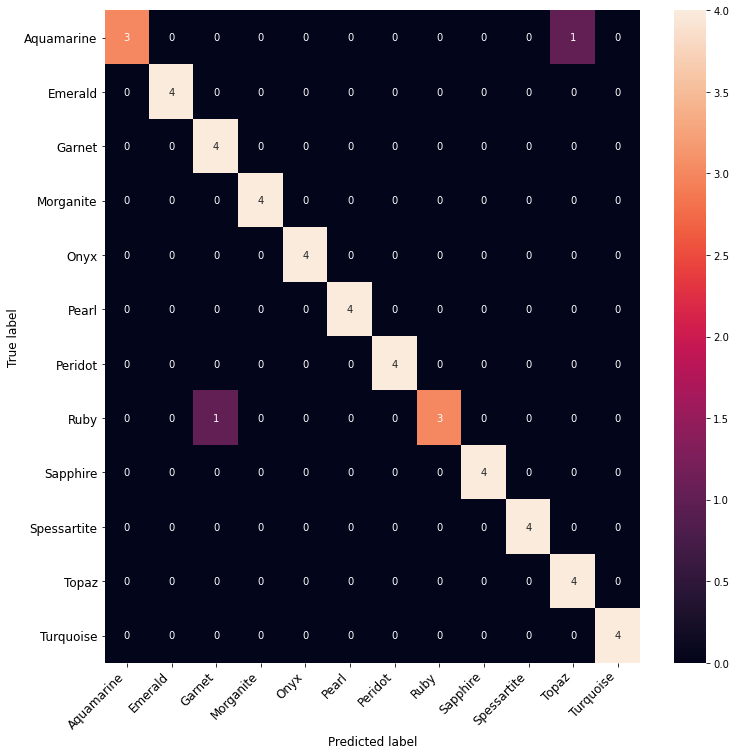

In [61]:
confusion = compute_confusion_matrix(metrics, labels)
plot_confusion_matrix(confusion,  labels, figsize=(12,12))

In [62]:
for i, label in enumerate(labels):
    correct = confusion[i, i]
    images_per_class = confusion[i].sum()
    print("%10s %.1f%%" % (label, 100. * correct/images_per_class))

Aquamarine 75.0%
   Emerald 100.0%
    Garnet 100.0%
 Morganite 100.0%
      Onyx 100.0%
     Pearl 100.0%
   Peridot 100.0%
      Ruby 75.0%
  Sapphire 100.0%
Spessartite 100.0%
     Topaz 100.0%
 Turquoise 100.0%
